In [166]:
import mdptoolbox as mdpt
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pprint as pp

In [289]:
 """Generate a MDP example based on a modified yahtzee inspired die game.
    This function is used to generate a transition probability
    (``A`` × ``S`` × ``S``) array ``P`` and a reward (``S`` × ``A``) matrix
    ``R`` that model the following problem. 
    The game is managed by two dice numbered {1-6} with each turn consisting of 
    four actions:
    - Re-roll blue die {action 0}
    - Re-roll red die  {action 1}
    - Re-roll both     {action 2}
    - Re-roll None     {action 3}
    
    An action is decided with the objective to maximize the final score 
    at the final state when the number of turns are over.
    
    Let {0, 1 . . . ``S``-1 } be the states of each turn and the resulting dice rolls.
    
    
    The transition matrix ``P`` of the problem can then be defined as follows::
                                | S111....... S113 |
                                | .                |
        P[Bl,:,0] = P[Rd,:,0] = | .  .  0  .       |
                                | S233  .          |
                                | .  .             |
                                | S366  0  0....   |
                   
                      | 0 0.........0 |
                      | . .         . |
        P[Both,:,0] = |(some gaussian)|
                      | . .         . |
                      | . .         . |
                      | 0 0.........0 |
                   
                      | 0 .......0 |
                      | .  0 ..... |
         P[None,:,:] =| .  .  0  . |
                      | 0 .......0 |
""" 
print

##### Plot Functions

In [290]:
def plotPolicy(filename, title, policy, gridsize):
    # initialization of grid
    side_len = gridsize[0]
    zeros = np.zeros(gridsize)
    x = np.linspace(0, side_len - 1, side_len) + 0.5
    y = np.linspace(side_len - 1, 0, side_len) + 0.5
    X, Y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(12,8))
    ax = plt.axes()
    
    max_ = 4
    min_ = 0
    # choose color scale
#     cmap = plt.cm.rainbow
    colors = plt.cm.Paired.colors
    # normalize
    norm = mpl.colors.Normalize(vmin=min_, vmax= max_)

    for i, _ in enumerate(policy):
        for j, action in enumerate(policy[i]):
            # Plot result
            if action == 0: # DoNothing
                # plot text
                plt.text(X[i,j], Y[i,j], 'do nothing', horizontalalignment ='center',
                        color = 'white', fontsize='large')
                # color grid
                ax.add_patch(
                    mpl.patches.Rectangle((X[i,j]-0.5, Y[i,j]-0.5), 1, 1, color='silver')
                )
            elif action == 1: # RerollBoth
                # plot text
                plt.text(X[i,j], Y[i,j], 're-roll both', horizontalalignment ='center',
                        color = 'white', fontsize='large')
                # color grid
                ax.add_patch(
                    mpl.patches.Rectangle((X[i,j]-0.5, Y[i,j]-0.5), 1, 1, 
                                          color=colors[8]))#cmap(norm(0))))
            elif action == 2: # RerollBlue
                # plot text
                plt.text(X[i,j], Y[i,j], 're-roll blue', horizontalalignment ='center',
                        color = 'white', fontsize='large')
                # color grid
                ax.add_patch(
                    mpl.patches.Rectangle((X[i,j]-0.5, Y[i,j]-0.5), 1, 1, 
                                          color=colors[0]))#cmap(norm(1))))
            elif action == 3: # RerollRed
                # plot text
                plt.text(X[i,j], Y[i,j], 're-roll red', horizontalalignment ='center',
                        color = 'white', fontsize='large')
                # color grid
                ax.add_patch(
                    mpl.patches.Rectangle((X[i,j]-0.5, Y[i,j]-0.5), 1, 1, 
                                          color=colors[4]))#cmap(norm(max_))))
            
            
    plt.title(title, fontsize='x-large')
    plt.xlim([0, side_len])
    plt.ylim([0, side_len])

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.grid()
    plt.show()
    fig.savefig('outputs/diceworld/' + filename + '.png', bbox_inches='tight', facecolor=fig.get_facecolor())

In [318]:
def plotValueFunc(filename, title, val_func, side_len):
    x = np.linspace(0, side_len - 1, side_len) + 0.5
    y = np.linspace(side_len - 1, 0, side_len) + 0.5
    X, Y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(12,8))
    ax = plt.axes()
    # choose color scale
    cmap = plt.cm.rainbow

    # add mapping
    min_val = float('{0:.2f}'.format(np.min(val_func)))
    max_val = float('{0:.2f}'.format(np.max(val_func)))
    norm = mpl.colors.Normalize(vmin=min_val, vmax= max_val)
    
    # add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, extend='both')

    # plot value function values and magnitudes
    for i, _ in enumerate(val_func):
        for j, action in enumerate(val_func[i]):
            plt.text(X[i,j], Y[i,j], '{0:.2f}'.format(val_func[i][j]),
                    horizontalalignment ='center', color = 'white', fontsize='x-large')
            ax.add_patch(
                mpl.patches.Rectangle((X[i,j]-0.5, Y[i,j]-0.5), 1, 1, 
                                      color=cmap(norm(val_func[i,j])))
            )
            
    plt.title(title, fontsize='x-large')
    plt.xlim([0, side_len])
    plt.ylim([0, side_len])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.grid()
    plt.show()
    fig.savefig('outputs/diceworld/' + filename + '.png', bbox_inches='tight', facecolor=fig.get_facecolor())

##### Set Up Dictionaries for converting between state indexes and enumerated states

In [292]:
Turns = 3
Blue = 6
Red = 6
S = Turns*Blue*Red
s = 0
gridsize = (6,6)

StatetoInt = {}
InttoState = {}
for t in range(Turns):
    StatetoInt[t+1] = {}
    for b in range(Blue):
        StatetoInt[t+1][b+1] = {}
        for r in range(Red):
            InttoState[s] = [t+1,b+1,r+1]
            StatetoInt[t+1][b+1][r+1] = s
            s = s+1

In [293]:
StatetoInt[1][6][4]

33

In [294]:
InttoState[33]

[1, 6, 4]

##### Transition Matrix

In [295]:
#Set up Do Nothing Matrix
DoNothing = np.zeros((S,S))
for s_from in range(S):
    state_array_from = InttoState[s_from]
    turn_from = state_array_from[0]
    blue_from = state_array_from[1]
    red_from = state_array_from[2]
    for s_to in range(S):
        state_array_to = InttoState[s_to]
        turn_to = state_array_to[0]
        blue_to = state_array_to[1]
        red_to = state_array_to[2]
        if((blue_from==blue_to) & (red_from == red_to) & (turn_from + 1 == turn_to)):
            DoNothing[s_from][s_to] = 1
        if((blue_from==blue_to) & (red_from == red_to) & (turn_from == 3) & (turn_to == 3)):
            DoNothing[s_from][s_to] = 1

In [296]:
np.sum(DoNothing, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

In [297]:
#Set up Reroll Both Matrix
RerollBoth = np.zeros((S,S))
for s_from in range(S):
    state_array_from = InttoState[s_from]
    turn_from = state_array_from[0]
    blue_from = state_array_from[1]
    red_from = state_array_from[2]
    for s_to in range(S):
        state_array_to = InttoState[s_to]
        turn_to = state_array_to[0]
        blue_to = state_array_to[1]
        red_to = state_array_to[2]
        if(turn_from + 1 == turn_to):
            RerollBoth[s_from][s_to] = 1.0/36
        if((blue_from==blue_to) & (red_from == red_to) & (turn_from == 3) & (turn_to == 3)):
            RerollBoth[s_from][s_to] = 1

In [298]:
np.sum(RerollBoth, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

In [299]:
DoNothing.shape

(108, 108)

In [300]:
#Set up Reroll Blue
RerollBlue = np.zeros((S,S))
for s_from in range(S):
    state_array_from = InttoState[s_from]
    turn_from = state_array_from[0]
    blue_from = state_array_from[1]
    red_from = state_array_from[2]
    for s_to in range(S):
        state_array_to = InttoState[s_to]
        turn_to = state_array_to[0]
        blue_to = state_array_to[1]
        red_to = state_array_to[2]
        if((red_from == red_to) & (turn_from + 1 == turn_to)):
            RerollBlue[s_from][s_to] = 1.0/6
        if((blue_from==blue_to) & (red_from == red_to) & (turn_from == 3) & (turn_to == 3)):
            RerollBlue[s_from][s_to] = 1

In [301]:
#Set up Reroll Blue
RerollRed = np.zeros((S,S))
for s_from in range(S):
    state_array_from = InttoState[s_from]
    turn_from = state_array_from[0]
    blue_from = state_array_from[1]
    red_from = state_array_from[2]
    for s_to in range(S):
        state_array_to = InttoState[s_to]
        turn_to = state_array_to[0]
        blue_to = state_array_to[1]
        red_to = state_array_to[2]
        if((blue_from == blue_to) & (turn_from + 1 == turn_to)):
            RerollRed[s_from][s_to] = 1.0/6
        if((blue_from==blue_to) & (red_from == red_to) & (turn_from == 3) & (turn_to == 3)):
            RerollRed[s_from][s_to] = 1

In [302]:
T = np.array([DoNothing,RerollBoth,RerollBlue,RerollRed])

In [303]:
import pprint
T.shape

(4, 108, 108)

In [304]:
discount = 0.9

##### Reward Matrix

In [305]:
#Set up Reward Matrix
R = np.zeros((S))
for s in range(S):
    state_array = InttoState[s]
    turn = state_array[0]
    blue = state_array[1]
    red = state_array[2]
    if(turn == 3):
        if (blue == red):
            r = 10
        else:
            r = blue - red
        R[s] = r

##### Value Iteration

In [326]:
vi = mdpt.mdp.ValueIteration(T, R, discount)
vi.run()

vi_policy = np.array(vi.policy).reshape(Turns, Blue, Red)
vi_val_func = np.array(vi.V).reshape(Turns, Blue, Red)
print("Learned value function", vi_val_func)
print("iterations", vi.iter)
print("time", vi.time)
print("policy: ")
pp.pprint(vi_policy)

print("key: DoNothing -> 0 , RerollBoth -> 1, RerollBlue -> 2, RerollRed -> 3")

('Learned value function', array([[[ 80.99314404,  36.22193386,  32.92221318,  32.92221318,
          32.92221318,  32.92221318],
        [ 42.74638158,  80.99314404,  32.92221318,  32.92221318,
          32.92221318,  32.92221318],
        [ 42.74638158,  36.22193386,  80.99314404,  32.92221318,
          32.92221318,  32.92221318],
        [ 42.74638158,  36.22193386,  32.92221318,  80.99314404,
          32.92221318,  32.92221318],
        [ 42.74638158,  36.22193386,  36.22193386,  36.22193386,
          80.99314404,  36.22193386],
        [ 42.74638158,  42.74638158,  42.74638158,  42.74638158,
          42.74638158,  80.99314404]],

       [[ 89.99314404,  28.49782895,  19.49851454,  14.99885734,
          14.99885734,  14.99885734],
        [ 37.49714335,  89.99314404,  19.49851454,  14.99885734,
          14.99885734,  14.99885734],
        [ 37.49714335,  28.49782895,  89.99314404,  14.99885734,
          14.99885734,  14.99885734],
        [ 37.49714335,  28.49782895,  19.498

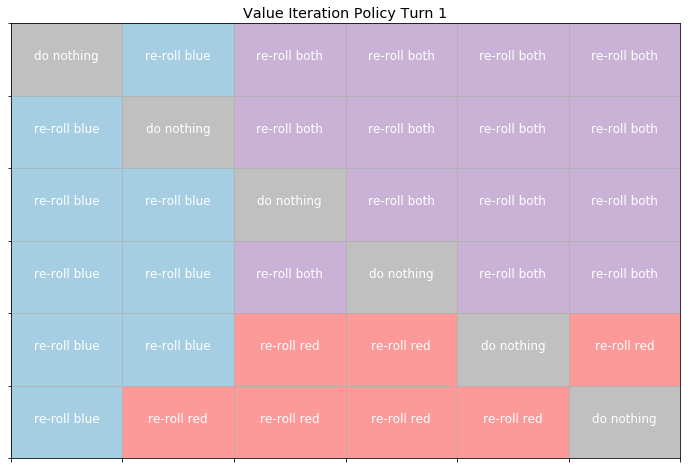

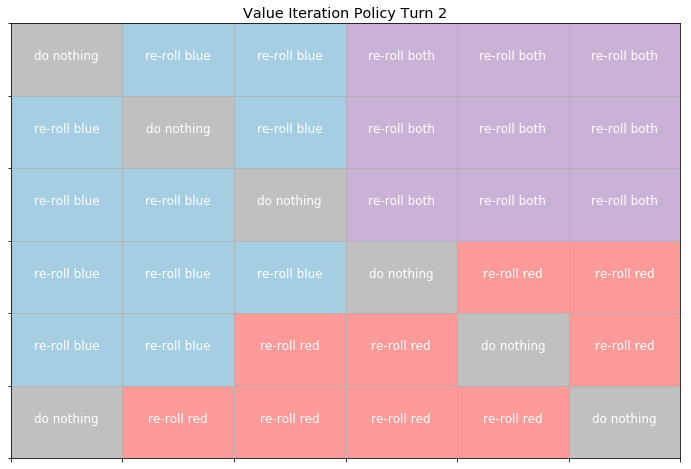

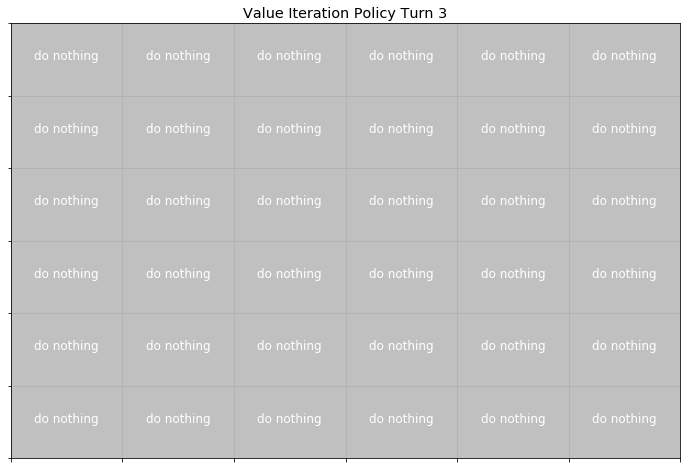

In [327]:
for t in range(Turns):
    plotPolicy('vi_policy' + str(t), 'Value Iteration Policy Turn ' + str(t+1), vi_policy[t], gridsize)

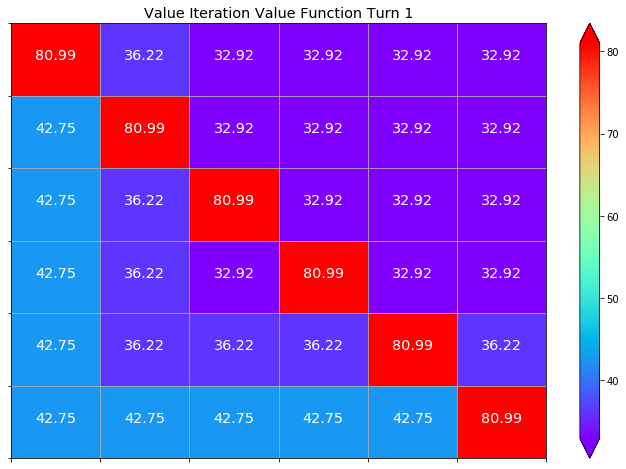

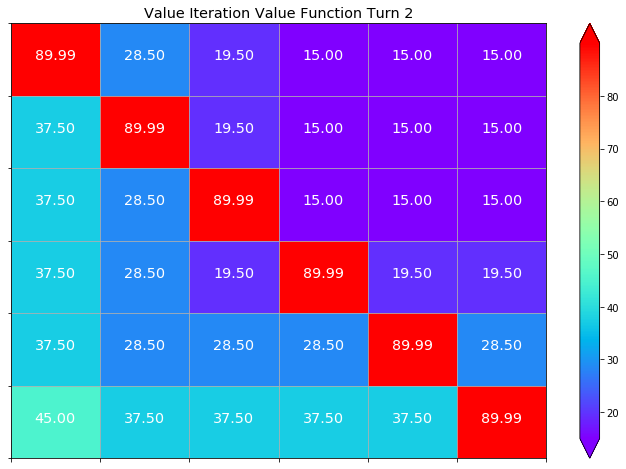

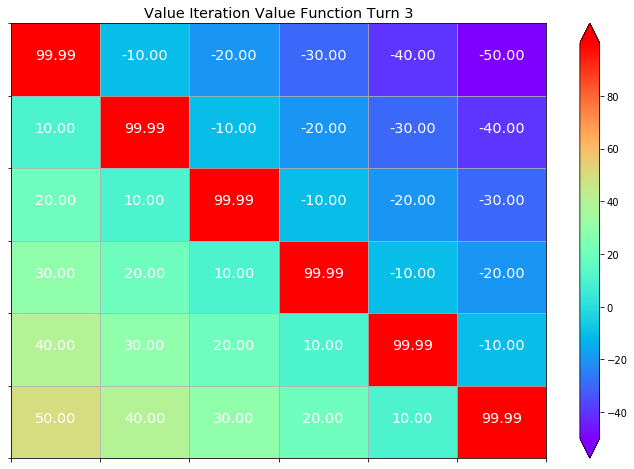

In [328]:
for t in range(Turns):
    plotValueFunc('vi_value_func' + str(t), 
                  'Value Iteration Value Function Turn ' + str(t+1), 
                  vi_val_func[t], gridsize[0])

##### Q Learning

In [312]:
ql = mdpt.mdp.QLearning(T, R, discount, n_iter=100000)
ql.run()

Q = ql.Q
pprint.pprint(Q)

ql_val_func = np.array(ql.V).reshape(Turns, Blue, Red)
print("Learned value function", q_val_func)

ql_policy = np.array(ql.policy).reshape(Turns, Blue, Red)
print("Learned optimal policy")
pprint.pprint(ql_policy)

q_mean_disc = np.array(ql.mean_discrepancy)
print("Vector of V discrepancy mean over 100 iterations: ", q_mean_disc)


array([[ 8.04740347e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 4.15008890e-03,  0.00000000e+00,  1.47042432e-02,
         0.00000000e+00],
       [ 1.86995010e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.83652113e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 2.68982627e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 3.75707548e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.93715914e-03,  1.15075370e-02,  0.00000000e+00,
         0.00000000e+00],
       [ 3.84971350e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  2.97503324e-02,  0.00000000e+00,
         0.00000000e+00],
       [ 6.20736550e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 2.54006145e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.97777564e-02,  0.00000000e+00,  0.00000000e+00,
      

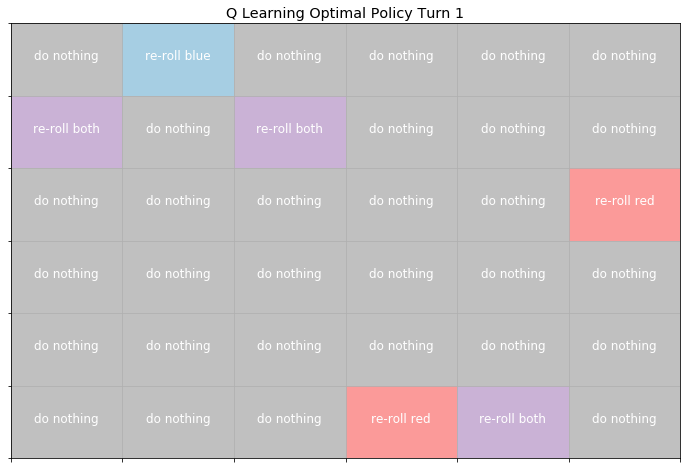

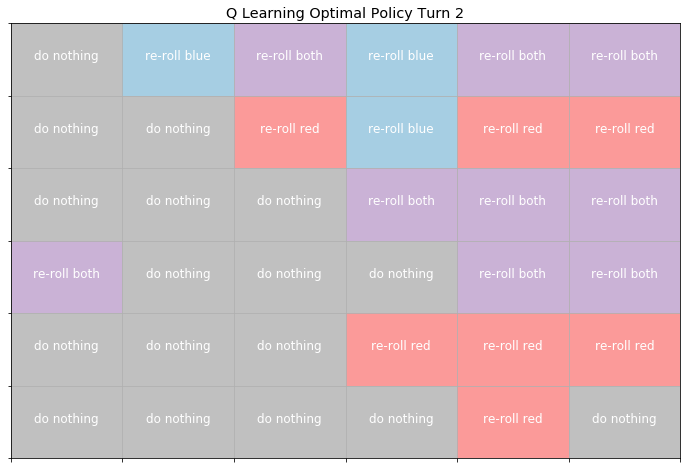

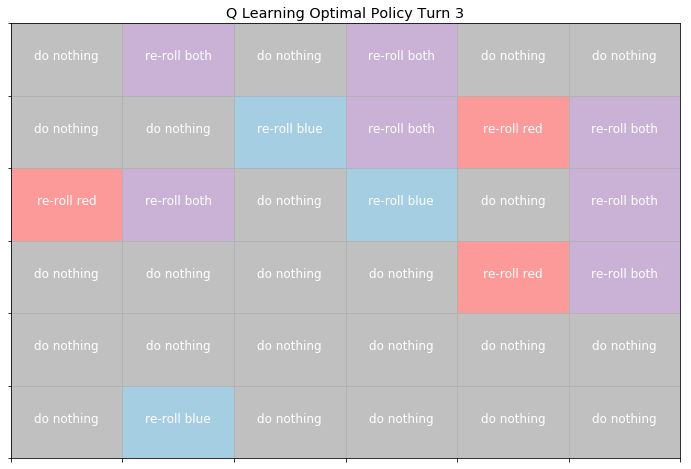

In [313]:
for t in range(Turns):
    plotPolicy('ql_policy' + str(t), 'Q Learning Optimal Policy Turn ' + str(t+1), ql_policy[t], gridsize)

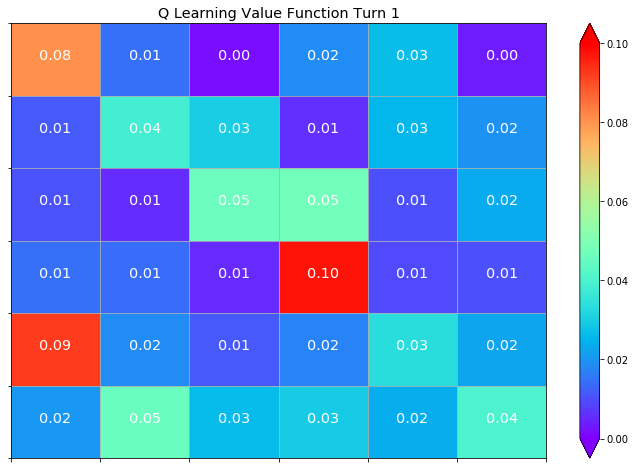

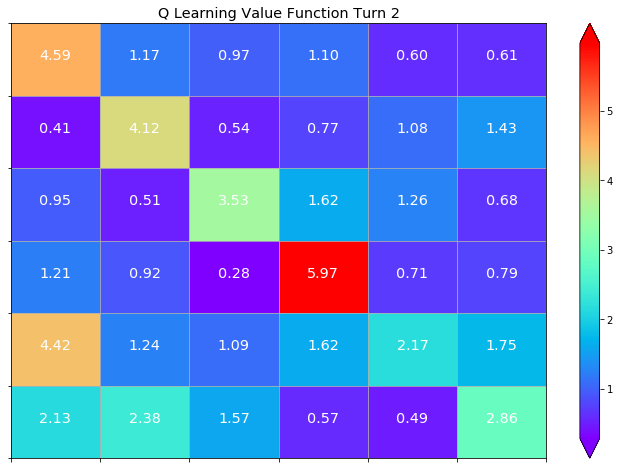

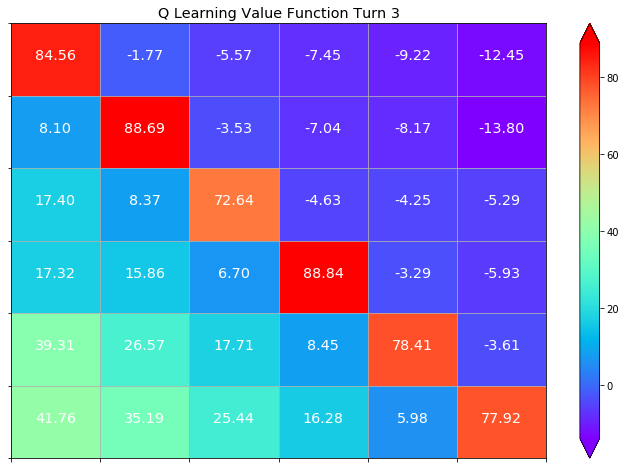

In [319]:
for t in range(Turns):
    plotValueFunc('ql_value_func' + str(t), 'Q Learning Value Function Turn ' + str(t+1), ql_val_func[t], gridsize[0])

##### Policy Iteration

In [315]:
pi = mdpt.mdp.PolicyIteration(T, R, discount)
pi.run()

pi_val_func = np.array(pi.V).reshape(Turns, Blue, Red)
print("Value Function: ", pi_val_func)
pi_policy = np.array(pi.policy).reshape(Turns, Blue, Red)
print
print("Optimal Policy: ", pi_policy)
print
print("Iterations: ", pi.iter)
print
print("Time: ", pi.time)



('Value Function: ', array([[[ 81.   ,  36.225,  32.925,  32.925,  32.925,  32.925],
        [ 42.75 ,  81.   ,  32.925,  32.925,  32.925,  32.925],
        [ 42.75 ,  36.225,  81.   ,  32.925,  32.925,  32.925],
        [ 42.75 ,  36.225,  32.925,  81.   ,  32.925,  32.925],
        [ 42.75 ,  36.225,  36.225,  36.225,  81.   ,  36.225],
        [ 42.75 ,  42.75 ,  42.75 ,  42.75 ,  42.75 ,  81.   ]],

       [[ 90.   ,  28.5  ,  19.5  ,  15.   ,  15.   ,  15.   ],
        [ 37.5  ,  90.   ,  19.5  ,  15.   ,  15.   ,  15.   ],
        [ 37.5  ,  28.5  ,  90.   ,  15.   ,  15.   ,  15.   ],
        [ 37.5  ,  28.5  ,  19.5  ,  90.   ,  19.5  ,  19.5  ],
        [ 37.5  ,  28.5  ,  28.5  ,  28.5  ,  90.   ,  28.5  ],
        [ 45.   ,  37.5  ,  37.5  ,  37.5  ,  37.5  ,  90.   ]],

       [[100.   , -10.   , -20.   , -30.   , -40.   , -50.   ],
        [ 10.   , 100.   , -10.   , -20.   , -30.   , -40.   ],
        [ 20.   ,  10.   , 100.   , -10.   , -20.   , -30.   ],
        [ 30.  

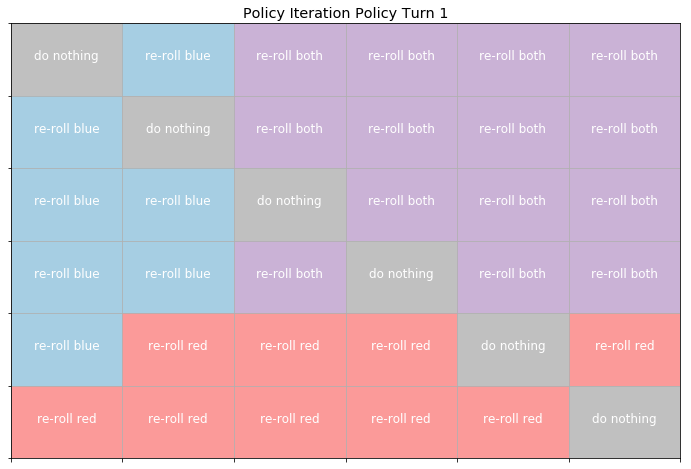

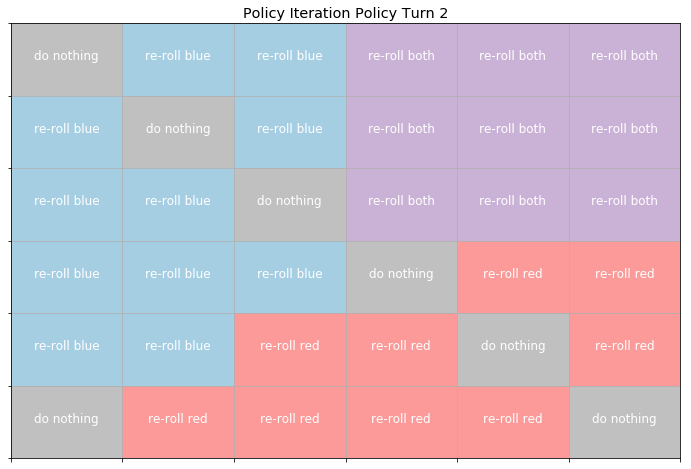

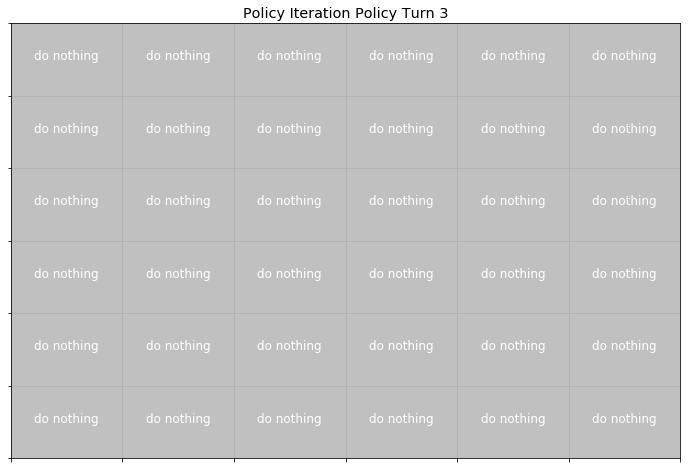

In [316]:
for t in range(Turns):
    plotPolicy('pi_policy' + str(t), 'Policy Iteration Policy Turn ' + str(t+1), pi_policy[t], gridsize)

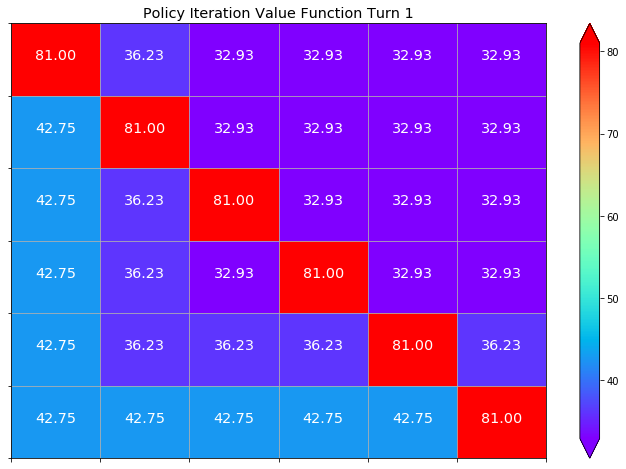

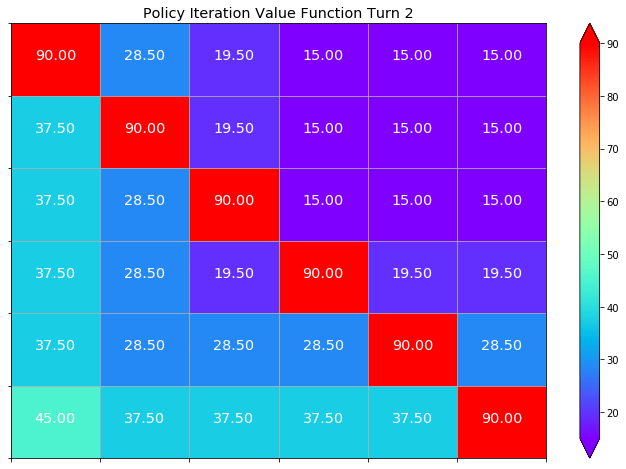

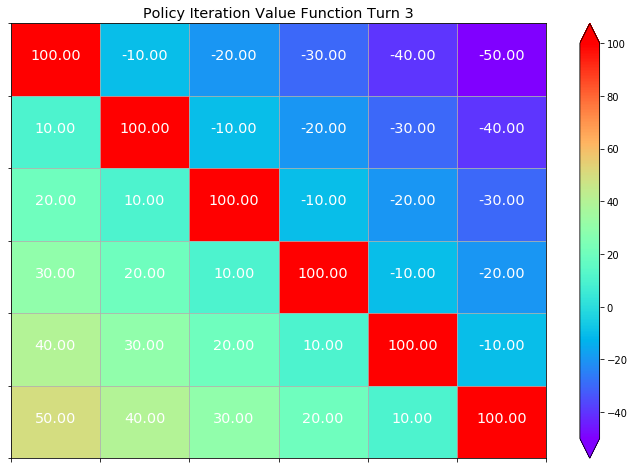

In [320]:
for t in range(Turns):
    plotValueFunc('pi_value_func' + str(t), 'Policy Iteration Value Function Turn ' + str(t+1), pi_val_func[t], gridsize[0])

##### MDP

In [122]:
x = mdpt.mdp.MDP(T, R, discount, 0.1, 100000)

print("Optimal Value Function ", x.V)
print( "Optimal Policy", x.policy)


('Optimal Value Function ', None)
('Optimal Policy', None)
